In [1]:
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import os

import random
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras import layers,models,optimizers
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

2023-02-24 17:18:05.099415: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
base_dir = '/Users/bui/Documents/UCSD/COGS181_Final Project/dogs-vs-cats'

# Check what's inside our folder
print(os.listdir(base_dir))

train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test1")

['IMG_6300.jpg', 'final_test.ipynb', '.DS_Store', 'sampleSubmission.csv', 'test1', 'train', 'test_2.ipynb']


In [3]:
print(os.listdir(train_dir)[1:10])

['cat.5077.jpg', 'dog.7322.jpg', 'cat.2718.jpg', 'cat.10151.jpg', 'cat.3406.jpg', 'dog.1753.jpg', 'cat.4369.jpg', 'cat.7660.jpg', 'dog.5535.jpg']


Looks like our Training File has labeled Cat and Dog for the photos. Used '.' to separate number of the photo. <br>
In this case, we will take advantage of this by first split file name by '.' (period), then if filename[0] (first index) == 'dog' => label 1, else label '0'

In [4]:
filenames = os.listdir(train_dir)
categories = []

for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

category_df = pd.DataFrame({'filename':filenames, 'category':categories})

In [5]:
# Check our Category (dog/cat) dataframe
category_df.head(8)

,filename,category
0,dog.8011.jpg,1
1,cat.5077.jpg,0
2,dog.7322.jpg,1
3,cat.2718.jpg,0
4,cat.10151.jpg,0
5,cat.3406.jpg,0
6,dog.1753.jpg,1
7,cat.4369.jpg,0


In [6]:
category_df['category'].value_counts()

1    12500
0    12500
Name: category, dtype: int64

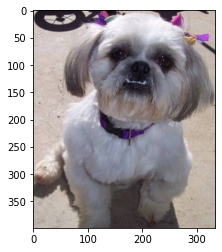

In [7]:
# Choose a random file to see
sample = random.choice(filenames)
img = load_img("train/" + sample)
plt.imshow(img)

Cats & Dogs Classifier

In [8]:
input_dimension = (128, 128, 3)
model=models.Sequential()

#input layer
model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=input_dimension))   
model.add(layers.MaxPooling2D((2,2)))
model.add(Dropout(0.20))  # avoid overfitting

model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(Dropout(0.20))  # avoid overfitting

model.add(layers.Conv2D(128,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(Dropout(0.20))  # avoid overfitting

model.add(layers.Conv2D(128,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(Dropout(0.20))  # avoid overfitting

# Output layer
model.add(layers.Flatten())   # Flatten before Dense
model.add(layers.Dense(32,activation='relu'))
model.add(Dropout(0.5))  # avoid overfitting
model.add(layers.Dense(32,activation='relu'))
model.add(layers.Dense(1,activation='softmax'))  # output has 2 neurons (dog or cat)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

2023-02-24 17:18:10.983381: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 30, 30, 64)        0

In [10]:
from sklearn.model_selection import train_test_split
category_df['category'] = category_df['category'].replace({0:'cat', 1:'dog'})
train_df, validate_df = train_test_split(category_df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [11]:
category_df.head(5)

,filename,category
0,dog.8011.jpg,dog
1,cat.5077.jpg,cat
2,dog.7322.jpg,dog
3,cat.2718.jpg,cat
4,cat.10151.jpg,cat


In [12]:
train_total = train_df.shape[0]
val_total = validate_df.shape[0]
batch_size = 20

print("Train Shape:", train_total)
print("Validation shape:", val_total)

Train Shape: 20000
Validation shape: 5000


In [13]:
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.2, horizontal_flip=True)
train_data = train_datagen.flow_from_dataframe(
                train_df, 'train/', x_col='filename', 
                y_col='category', target_size=(128, 128), class_mode='categorical', batch_size=batch_size)

Found 20000 validated image filenames belonging to 2 classes.


In [14]:
val_datagen = ImageDataGenerator(rescale=1./255)
val_data = val_datagen.flow_from_dataframe(
            validate_df, 'train/', x_col='filename', 
            y_col='category', target_size=(128, 128), class_code='categorical', batch_size=batch_size)

Found 5000 validated image filenames belonging to 2 classes.


In [15]:
print(val_data.class_indices)
print(val_data.n)   # n sample?
print(len(val_data))

{'cat': 0, 'dog': 1}
5000
250


In [19]:
print(tf.test.gpu_device_name())

In [17]:
# model.reset_state()

AttributeError: 'Sequential' object has no attribute 'reset_state'

In [21]:
fitted_model = model.fit_generator(train_data, epochs=10, validation_steps=val_total//batch_size, steps_per_epoch=train_total//batch_size, validation_data=val_data)

/var/folders/_0/541h7pgs06l9wr3xp3jssnsc0000gn/T/ipykernel_19883/2891834729.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  fitted_model = model.fit_generator(train_data, epochs=10, validation_steps=val_total//batch_size, steps_per_epoch=train_total//batch_size, validation_data=val_data)


Epoch 1/10
1000/1000 [==============================] - 301s 300ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/10
1000/1000 [==============================] - 297s 297ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/10
1000/1000 [==============================] - 275s 275ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/10
1000/1000 [==============================] - 285s 285ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/10
1000/1000 [==============================] - 304s 304ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 6/10
1000/1000 [==============================] - 303s 302ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 7/10
1000/1000 [==============================] - 294s 294ms/step - loss: 0.6932 - accuracy: 0.5000 - val_

In [26]:
# model.fit_generator(train_data, epochs=10, validation_steps=1000, steps_per_epoch=1000, validation_data=val_data)

/var/folders/_0/541h7pgs06l9wr3xp3jssnsc0000gn/T/ipykernel_19591/2441733441.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_data, epochs=10, validation_steps=1000, steps_per_epoch=1000, validation_data=val_data,)


Epoch 1/10
1000/1000 [==============================] - 295s 295ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 2/10
1000/1000 [==============================] - 280s 280ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 3/10
1000/1000 [==============================] - 291s 291ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 4/10
1000/1000 [==============================] - 266s 266ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 5/10
1000/1000 [==============================] - 287s 287ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 6/10
1000/1000 [==============================] - 283s 283ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 7/10
1000/1000 [==============================] - 283s 283ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 8/10
1000/1000 [==============================] - 291s 291ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 9/10
1000/1000 [==============================] - 305s 304ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 10/10
1000/1000 [=======================

In [25]:
fitted_model.history['acc']

KeyError: 'acc'

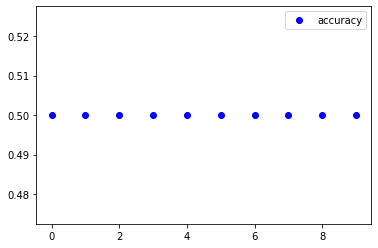

In [26]:
# plotting accuracy and validation accuracy
accuracy = fitted_model.history['accuracy']
plt.plot(range(len(accuracy)), accuracy, 'bo', label = 'accuracy')
plt.legend()

In [10]:
# from sklearn.model_selection import train_test_split

# train_df, val_df = train_test_split(category_df, test_size=0.2,random_state=42 )

# train_df = train_df.reset_index(drop=True)
# val_df = val_df.reset_index(drop=True)

# print("Train Value Counts")
# print(train_df.category.value_counts())
# print("Validation Value Counts")
# print(val_df.category.value_counts())

# train_size = train_df.shape[0]
# val_size = val_df.shape[0]


In [11]:
# batch_size = 32
# # Convert RGB into array of numbers
# datagen = ImageDataGenerator(rescale=1.0/255.0, zoom_range=0.2)

# train_set = datagen.flow_from_directory(
#             train_dir, target_size=(64,64), batch_size=batch_size, class_mode='binary'
# )

# # test_set = datagen.flow_from_directory(
# #             test_dir, target_size=(64,64), batch_size=batch_size, class_mode='binary'
# # )

Blurring?

In [12]:
# from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
# input_dimension = (200, 200, 3)
# model=models.Sequential()
# labels = 5

# #input layer
# model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=input_dimension))   
# model.add(layers.MaxPooling2D((2,2)))
# model.add(Dropout(0.25))  # avoid overfitting

# # Layer 2
# model.add(layers.Conv2D(64,(3,3),activation='relu'))
# model.add(layers.MaxPooling2D((2,2)))
# model.add(Dropout(0.5))
# model.add(Flatten())

# # Layer 3
# model.add(Dense(250, activation='relu'))
# model.addd(Dropout(0.5))

# # Layer 4 (output)
# model.add(Dense(labels, activation='softmax'))

# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# model.summary()